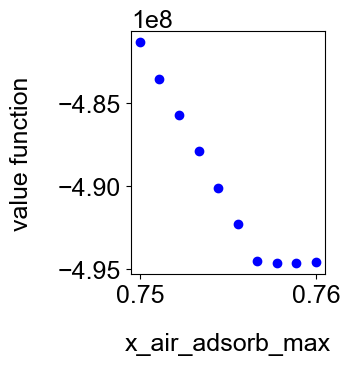

FLECCS executed


In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from pyomo.opt import SolverFactory, TerminationCondition
from src.analyses.value_function import ValueFunction
from src.analyses.convergence_analysis import HausdorffAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from scipy.optimize import curve_fit
from NSPLIB.src.instances.FLECCS.src.pyomo_model.model import const_model
fleccs_obj = -4.946928843629e+08  # Replace with actual value
fleccs_sol = {'x_sorbent_total': 0.7571021770410511,'x_air_adsorb_max': 0.7567643358197031} 
fleccs_y_bound = {'x_sorbent_total': [0.0, 1.0],"x_air_adsorb_max": [0.0, 1.0]}

n_day = 7
week_diff = 52
sto_m = const_model(n_day=n_day, week_diff=week_diff)
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()
v_f= ValueFunction(m,solver="gurobi")
v_f.calc_1D(idx="x_air_adsorb_max", y_val_fix=fleccs_sol,
                interval= [0.75,0.76], step = 10)
v_f.plot_1D()
plt.show()
print("FLECCS executed")